In [1]:
import pandas as pd
import numpy as np
import datetime

from sklearn.datasets import load_breast_cancer


from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


# Import Pandas for data manipulation purposes 

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

#Logistic Regression
from sklearn.linear_model import LogisticRegression

#Decision TREES
from sklearn.tree import DecisionTreeClassifier

# regularized regression with Ridge absolute value alpha
from sklearn.linear_model import Lasso


#for confusion matrix
from sklearn.metrics import confusion_matrix
#for having clasification reports
from sklearn.metrics import classification_report
#ROC curve for analyzing Logistic regression
from sklearn.metrics import roc_curve
# Cross Validation Score
from sklearn.model_selection import cross_val_score
# Calculate AUC Score
from sklearn.metrics import roc_auc_score

#an algotithm to normalize the numbers by dividing them to thairs std
from scipy.cluster.vq import whiten

from sklearn.metrics import r2_score, accuracy_score
from scipy.stats import spearmanr, pearsonr


from sklearn.ensemble import RandomForestClassifier

from sklearn.datasets import make_hastie_10_2
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification


from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

from sklearn.svm import SVC


In [2]:
# Pr. Houdart functions

from pandas             import DataFrame
from pandas             import Series
from pandas             import read_csv
from numpy              import array
from numpy              import random


def roc (dataSet: DataFrame, actuals: str, probability: str) -> DataFrame:

    (fpr,tpr,threshold) = roc_curve(array(dataSet[actuals]), array(dataSet[probability]), pos_label = 1)

    returnData = DataFrame(tpr)
    returnData.columns = ["True positive rate"]
    returnData["False positive rate"] = DataFrame(fpr)

    return returnData

def lift (dataSet: DataFrame, actuals: str, probability: str, precision: int = 20) -> DataFrame:

    summary = cumulativeResponse(dataSet = dataSet, actuals = actuals, probability = probability, precision = precision)

    summary["Lift"] = summary["Cumulative response"] / Series(summary["Average response"]).max()
    summary["Base"] = summary["Average response"] / Series(summary["Average response"]).max()

    return summary[["Quantile","Lift","Base"]]

def cumulativeResponse (dataSet: DataFrame, actuals: str, probability: str, precision: int = 20) -> DataFrame:

    internalSet = equifrequentBinning (dataSet = dataSet[[actuals, probability]], byColumn = probability, into = precision)

    internalSet["Quantile"] = internalSet[probability + "_bin"] / precision
    internalSet["obs"]      = 1

    summary = internalSet[["Quantile", actuals, "obs"]].groupby(["Quantile"], as_index = False).sum().sort_values(by = "Quantile", ascending = False)

    summary["cumulativeTarget"]     = Series(summary[actuals]).cumsum(skipna = False)
    summary["cumulativeAll"]        = Series(summary["obs"]).cumsum(skipna = False)
    summary["Cumulative response"]  = summary["cumulativeTarget"] / summary["cumulativeAll"]
    summary["Average response"]     = Series(summary["cumulativeTarget"]).max() / Series(summary["cumulativeAll"]).max()

    return summary[["Quantile","Cumulative response","Average response"]]

def cumulativeGains (dataSet: DataFrame, actuals: str, probability: str, precision: int = 20) -> DataFrame:

    internalSet = equifrequentBinning (dataSet = dataSet[[actuals, probability]], byColumn = probability, into = precision)

    internalSet["Quantile"] = internalSet[probability + "_bin"] / precision
    internalSet["obs"]      = 1

    summary = internalSet[["Quantile", actuals, "obs"]].groupby(["Quantile"], as_index = False).sum().sort_values(by = "Quantile", ascending = False)

    summary["cumulativeTarget"]     = Series(summary[actuals]).cumsum(skipna = False)
    summary["cumulativeAll"]        = Series(summary["obs"]).cumsum(skipna = False)
    summary["Cumulative gains"]     = summary["cumulativeTarget"] / Series(summary["cumulativeTarget"]).max()
    summary["Base"]                 = summary["Quantile"]

    return summary[["Quantile","Cumulative gains","Base"]]

def equifrequentBinning (dataSet: DataFrame, byColumn: str, into: int) -> DataFrame:

    internalSet = dataSet

    quanitles = []

    for i in range(into):
        quanitles.append(1 / into * (i))

    quantile = internalSet.quantile(quanitles, axis = 0)[byColumn].to_dict()

    internalSet["Bin"] = 0

    for q in quantile:
        upperBound = quantile[q]
        internalSet.loc[internalSet[byColumn] >= upperBound, byColumn + "_bin"] = int(q * into +1)

    return internalSet

def partition (dataFrame : DataFrame, splitStrategy: [float]) -> [DataFrame]:

    def assignPartition (toDataFrame: DataFrame, lowerBound: float, upperBound: float, index: int) -> int:
        if toDataFrame["random"] >= lowerBound * observations and toDataFrame["random"] < upperBound * observations:
            return index
        else:
            return int(toDataFrame["Split"])

    if type(splitStrategy) != list:
        raise KeyError("Split strategy must be an array of floating point values.")
    elif sum(splitStrategy) != 1:
        raise ValueError("Split strategy must sum to 1.")
    else:
        observations = dataFrame.shape[0]
        partitions   = len(splitStrategy)

        cumulativeSplit = 0

        data = dataFrame.copy()
        data["random"] = random.permutation(observations)
        data["Split"]  = 0

    for index, split in enumerate(splitStrategy):
        lowerSplit = cumulativeSplit
        upperSplit = cumulativeSplit + split + 1
        cumulativeSplit += split
        data["Split"] = data.apply(lambda x: assignPartition(x,lowerSplit,upperSplit,index+1), axis = 1)

    partitions = []

    for i in range(len(splitStrategy)):
        partitions.append(data.loc[data["Split"] == i+1].drop(["Split","random"], axis = 1).reset_index(drop = True))

    return partitions

In [16]:
base_6169=pd.read_csv("./data/gift_base_6169.csv")
base_7244=pd.read_csv("./data/gift_base_7244.csv")
base_7362=pd.read_csv("./data/gift_base_7362.csv")

In [17]:
for col in base_6169.columns:
    base_6169[col]=base_6169[col].fillna(0)

for col in base_7244.columns:
    base_7244[col]=base_7244[col].fillna(0)

for col in base_7362.columns:
    base_7362[col]=base_7362[col].fillna(0)

In [18]:
base_6169 = base_6169.drop(['dateOfBirth', 'total_donated_during_dv'], axis = 1)
base_7244 = base_7244.drop(['dateOfBirth', 'total_donated_during_dv'], axis = 1)


In [19]:
X=base_6169.drop(["donated_more_than30_duringdv"],axis=1)
y=base_6169['donated_more_than30_duringdv']
testX=base_7244.drop(['donated_more_than30_duringdv'],axis=1)
testy=base_7244['donated_more_than30_duringdv']

In [20]:
Xtrain,Xtest,ytrain,ytest=train_test_split(X,y,test_size=0.3,stratify=y,random_state=613)
np.random.seed(90)
lr = GradientBoostingClassifier()
lr.fit(Xtrain,ytrain)
predict_test=lr.predict(testX)
predict_train=lr.predict(X)
acc_train = accuracy_score(y, np.round(predict_train))
acc_test = accuracy_score(testy, np.round(predict_test))

print(f"Train:\tACC={acc_train:.4f}")
print(f"Test:\tACC={acc_test:.4f}")

Train:	ACC=0.9768
Test:	ACC=0.9912


In [21]:
print(classification_report(testy, predict_test))
scores = cross_val_score(lr, X, y, cv=5)
scores

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     25428
           1       0.20      0.01      0.03       217

    accuracy                           0.99     25645
   macro avg       0.60      0.51      0.51     25645
weighted avg       0.98      0.99      0.99     25645



array([0.02980797, 0.97477787, 0.97363141, 0.97563423, 0.03955855])

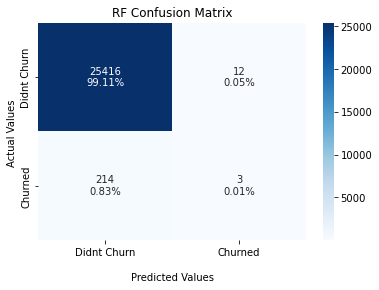

In [22]:

from sklearn.metrics import confusion_matrix

#Generate the confusion matrix

cf_matrix = confusion_matrix(testy, np.round(predict_test))

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

# Plot correlation Matrix
ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

ax.set_title('RF Confusion Matrix');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Didnt Churn','Churned'])
ax.yaxis.set_ticklabels(['Didnt Churn','Churned'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [23]:
probabilities = DataFrame(lr.predict_proba(testX))[1]
auc           = roc_auc_score(array(testy),array(probabilities))

In [24]:
y_pred_prob = lr.predict_proba(testX)[:,1]
fpr,tpr,thresholds=roc_curve(testy,y_pred_prob)


C:\Users\MALIPO~1\AppData\Local\Temp/ipykernel_25336/3583084210.py:1: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0,1],[0,1],'k--', color="#876123")


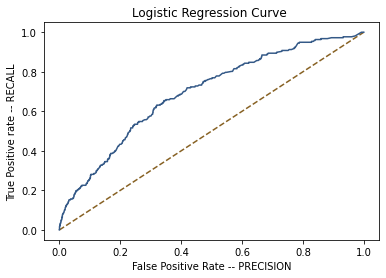

In [25]:
plt.plot([0,1],[0,1],'k--', color="#876123")
plt.plot(fpr,tpr,color='#345987')
plt.xlabel("False Positive Rate -- PRECISION")
plt.ylabel("True Positive rate -- RECALL")
plt.title("Logistic Regression Curve ")
plt.show()

In [35]:
from xgboost import XGBClassifier

In [36]:
# instanciate the models
tree         = DecisionTreeClassifier()
logistic     = LogisticRegression(max_iter = 1000)
randomForest = RandomForestClassifier(n_estimators = 700)
boostedTree  = GradientBoostingClassifier()
XGB          = XGBClassifier()
neuralNet    = MLPClassifier()
neighbors    = KNeighborsClassifier()

In [42]:
# create a dict to loop through the models later on
models = {"tree"         :tree,
          "logistic"     :logistic,
          "randomForest" :randomForest,
          "boostedTree"  :boostedTree,
          "neuralNet"    :neuralNet,
          "neighbors"    :neighbors,
          "XGB"          :XGB
         }

In [43]:
# fit the models
for model in models:
    models[model].fit(Xtrain,ytrain)
    print(f"{model} has been trained successfully")

tree has been trained successfully
logistic has been trained successfully
randomForest has been trained successfully
boostedTree has been trained successfully
neuralNet has been trained successfully
neighbors has been trained successfully
[19:41:16] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\tools\Anaconda3\envs\py\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGB has been trained successfully


In [44]:
from numpy                  import array
from pandas                 import DataFrame

In [45]:
# AUC

performances = {}

for model in models:
    predictions   = models[model].predict(testX)
    probabilities = DataFrame(models[model].predict_proba(testX))[1]
    accuracy      = accuracy_score(testy,predictions)
    auc           = roc_auc_score(array(testy),array(probabilities))
    
    performances[model] = {"Accuracy":accuracy,"AUC":auc}

In [46]:
pd.DataFrame(performances)

,tree,logistic,randomForest,boostedTree,neuralNet,neighbors,XGB
Accuracy,0.908442,0.991499,0.991304,0.990446,0.991538,0.991304,0.984012
AUC,0.547192,0.548875,0.661415,0.690726,0.500000,0.507434,0.710714


In [54]:

target='donated_more_than30_duringdv'
lifts     = {}
responses = {}
gains     = {}
data      = DataFrame(testy).copy() 

for (index,model) in enumerate(models):
    data[f"proba {model}"] = DataFrame(models[model].predict_proba(testX))[1]
    lifts[model] = lift(dataSet = data, actuals = target, probability = "proba "+str(model))
    responses[model] = cumulativeResponse(dataSet = data, actuals = target, probability = "proba "+str(model))
    gains[model] = cumulativeGains(dataSet = data, actuals = target, probability = "proba "+str(model))



C:\Users\MALIPO~1\AppData\Local\Temp/ipykernel_25336/2576955810.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  internalSet["Bin"] = 0
C:\Users\MALIPO~1\AppData\Local\Temp/ipykernel_25336/2576955810.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  internalSet["Bin"] = 0
C:\Users\MALIPO~1\AppData\Local\Temp/ipykernel_25336/2576955810.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

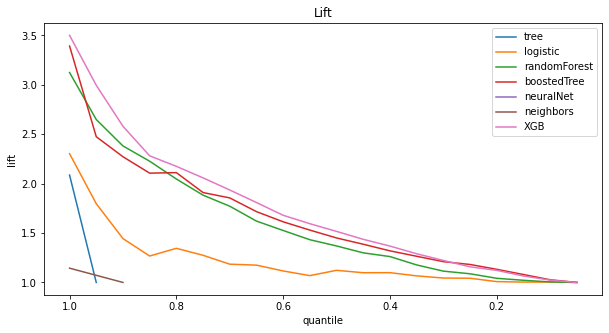

In [56]:
plt.figure(figsize=(10,5))

for model in models:
    plt.plot(lifts[model]["Quantile"], lifts[model]["Lift"], label=model)
    plt.gca().invert_xaxis()
    plt.xlabel("quantile")
    plt.ylabel("lift")
    plt.title("Lift")
    plt.legend(loc="upper right")



In [62]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.scalibration import CalibrationDisplay
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

lr           = LogisticRegression(C=1.0,max_iter = 1000)
gnb          = GaussianNB()
gnb_isotonic = CalibratedClassifierCV(gnb, cv=2, method="isotonic")
gnb_sigmoid  = CalibratedClassifierCV(gnb, cv=2, method="sigmoid")
tree         = DecisionTreeClassifier()
randomForest = RandomForestClassifier(n_estimators = 700)
boostedTree  = GradientBoostingClassifier()
svm          = SVC(gamma = "scale", probability = True)
neuralNet    = MLPClassifier()
neighbors    = KNeighborsClassifier()
XGB          = XGBClassifier()


clf_list = [
    (lr, "Logistic"),
    (gnb, "Naive Bayes"),
    (gnb_isotonic, "Naive Bayes + Isotonic"),
    (gnb_sigmoid, "Naive Bayes + Sigmoid"),
    (tree,"tree"),
    (randomForest,"randomForest"),
    (boostedTree,"boostedTree"),
    (svm,"SVC"),
    (neuralNet,"neuralNet"),
    (neighbors,"neighbors"),
    (XGB,"XGB")
]

C:\tools\Anaconda3\envs\py\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:56:48] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


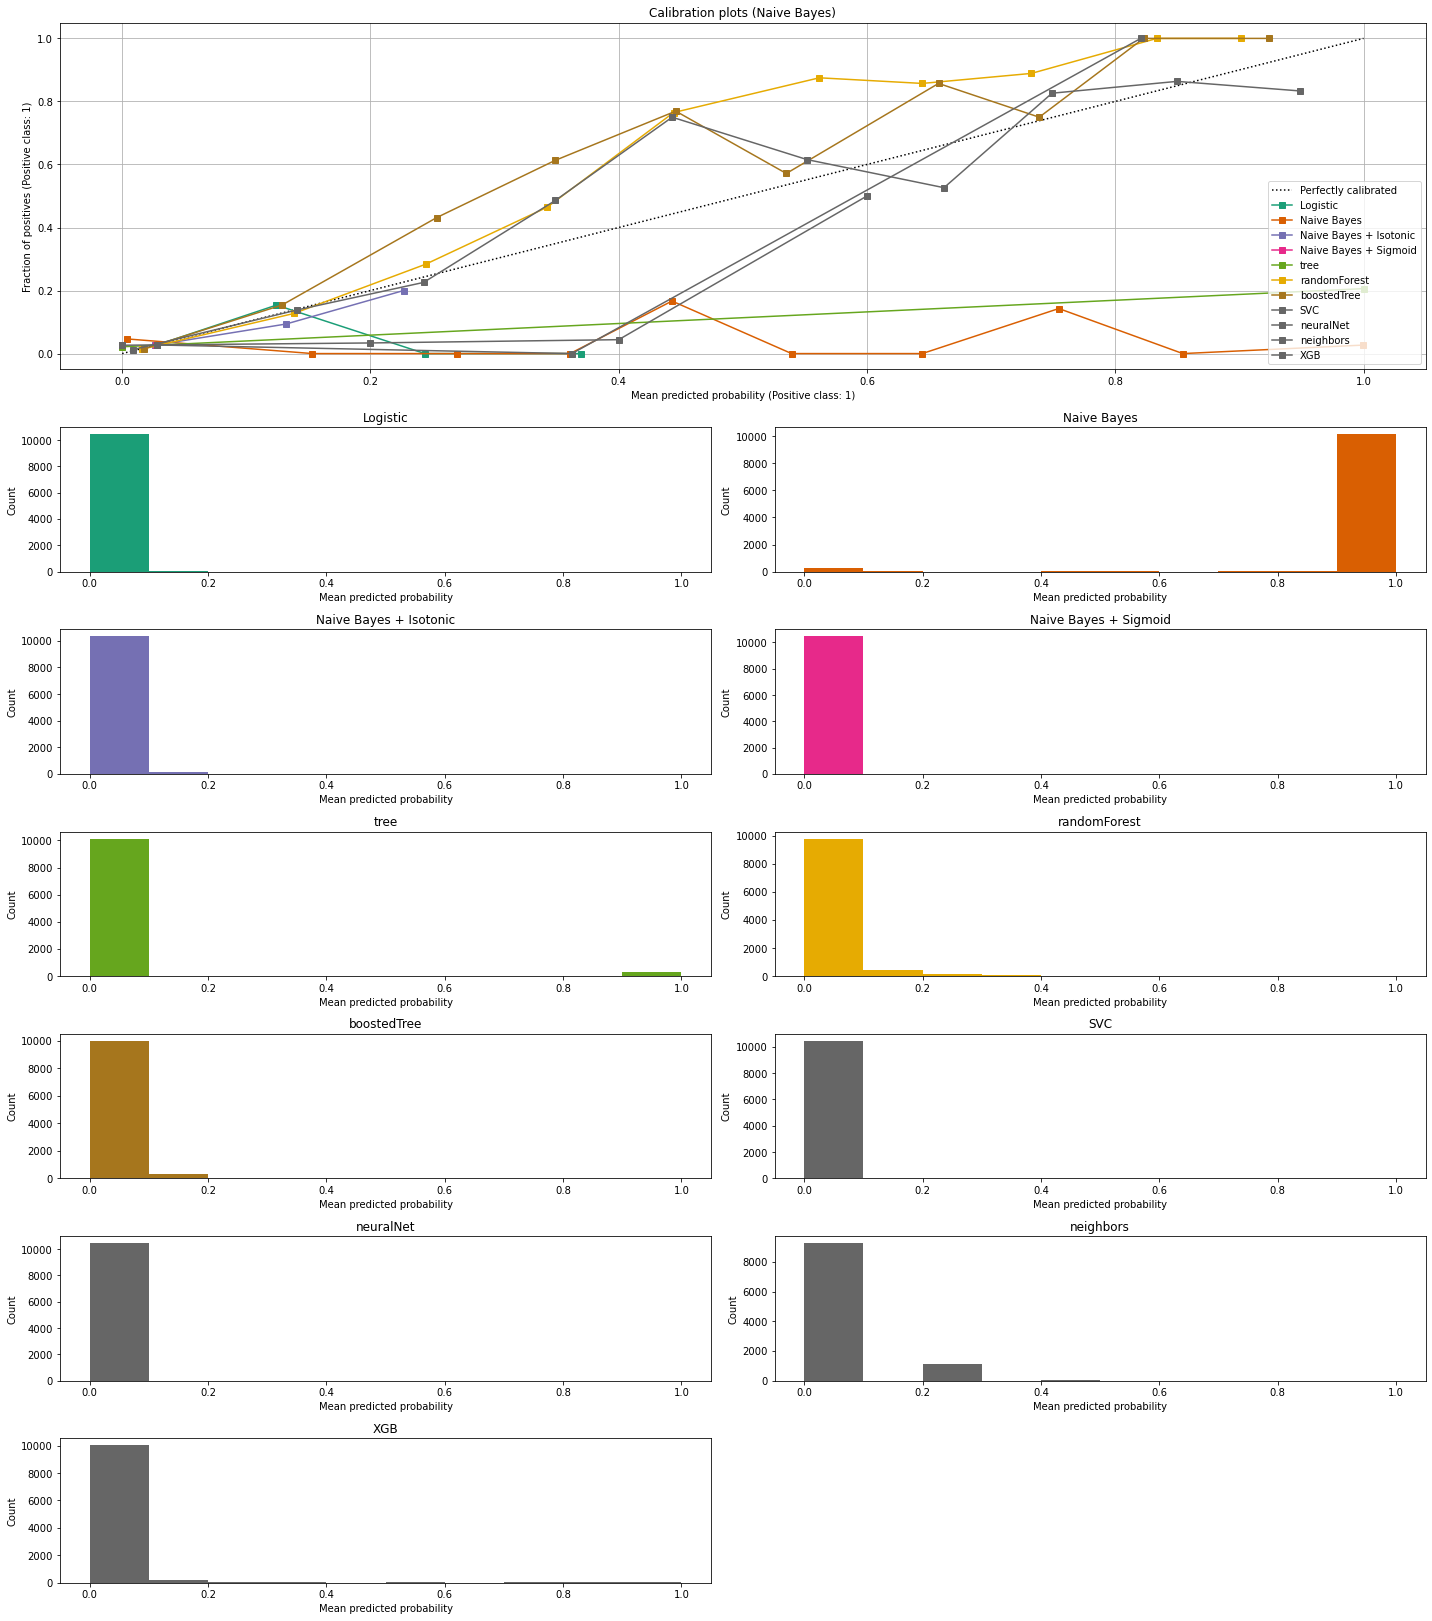

In [66]:
fig = plt.figure(figsize=(20, 25))
gs = GridSpec(9, 2)
colors = plt.cm.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
for i, (clf, name) in enumerate(clf_list):
    clf.fit(Xtrain, ytrain)
    display = CalibrationDisplay.from_estimator(
        clf,
        Xtest,
        ytest,
        n_bins=10,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
    )
    calibration_displays[name] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plots (Naive Bayes)")

# Add histogram
grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1),(4,0),(4,1),(5,0),(5,1),(6,0),(6,1),(7,0),(7,0)]
for i, (_, name) in enumerate(clf_list):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[name].y_prob,
        range=(0, 1),
        bins=10,
        label=name,
        color=colors(i),
    )
    ax.set(title=name, xlabel="Mean predicted probability", ylabel="Count")

plt.tight_layout()
plt.show()
